## 1. Preprocessing
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Data/Bank_Customer_Churn_Data.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df_train = pd.read_csv('../Data/df_train.csv')
df_train.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15601116,686,France,Male,32,6,0.00,2,1,1,179093.26,0
1,15766374,632,Germany,Male,42,4,119624.60,2,1,1,195978.86,0
2,15716994,559,Spain,Male,24,3,114739.92,1,1,0,85891.02,1
3,15730759,561,France,Female,27,9,135637.00,1,1,0,153080.40,1
4,15797900,517,France,Male,56,9,142147.32,1,0,0,39488.04,1


In [4]:
df_test = pd.read_csv('../Data/df_test.csv')
df_test.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15687492,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,0
1,15736963,623,France,Male,43,1,0.00,2,1,1,146379.30,0
2,15721730,601,Spain,Female,44,4,0.00,2,1,0,58561.31,0
3,15762134,506,Germany,Male,59,8,119152.10,2,1,1,170679.74,0
4,15648898,560,Spain,Female,27,7,124995.98,1,1,1,114669.79,0


### Apply Encoder

In [5]:
# Apply OrdinalEncoder to 'country'

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(categories=[['France', 'Spain', 'Germany']],
                     handle_unknown='use_encoded_value',unknown_value = -1)
df_train[['country']] = enc.fit_transform(df_train[['country']])
df_test[['country']] = enc.fit_transform(df_test[['country']])

In [6]:
# Apply OneHotEncoder to 'gender'
# Male = 1
# Female = 0

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore',drop='first')
df_train['gender'] = ohe.fit_transform(df_train[['gender']].to_numpy().reshape(-1, 1)).toarray()
df_test['gender'] = ohe.fit_transform(df_test[['gender']].to_numpy().reshape(-1, 1)).toarray()

### Create New Features

In [7]:
df_train['country*estimated_salary'] = df_train['country'] * df_train['estimated_salary']
df_test['country*estimated_salary'] = df_test['country'] * df_test['estimated_salary']

In [8]:
df_train['country*balance'] = df_train['country'] * df_train['balance']
df_test['country*balance'] = df_test['country'] * df_test['balance']

### Define X_train, y_train, X_test and y_test

In [9]:
# define X_train and y_train
X_train = df_train.drop('churn', axis=1)
y_train = df_train['churn']

In [10]:
# define X_test and y_test
X_test = df_test.drop('churn', axis=1)
y_test = df_test['churn']

### Balance the Data

In [11]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [12]:
Counter(y_train)

Counter({0: 6356, 1: 1644})

There are about 6,500 data who will not churn and 1,500 data who will churn.

As there is an imbalance data, we will have to balance the data.

In [13]:
s = 42

In [14]:
smote = SMOTE(random_state=s)

In [15]:
X_train_b, y_train_b = smote.fit_resample(X_train, y_train)
Counter(y_train_b)

Counter({0: 6356, 1: 6356})

### Variance Inflation Factor (VIF)

In [16]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
# VIF dataframe
x_temp = sm.add_constant(X_train_b)

vif = pd.DataFrame()
vif['vif_factor'] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif['features'] = x_temp.columns
vif.round(5).sort_values(by='vif_factor', ascending=False)

,vif_factor,features
0,47794.29669,const
3,10.13970,country
13,8.85629,country*balance
12,5.01648,country*estimated_salary
11,1.98085,estimated_salary
7,1.88971,balance
8,1.07795,products_number
10,1.02353,active_member
5,1.01817,age
9,1.01357,credit_card


There seems to be high correlation between *'country'*, *'country x balance'*, *'country x estimated_salary'*, *'estimated_salary'* and *'balance'*, which is expected as *'country x balance'* and *'country x estimated_salary'* are derived features from *'country'*, *'balance'* and *'estimated_salary'*.

### SelectKBest

In [18]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression

In [19]:
kbest = SelectKBest(score_func=chi2, k=13)
X_new = kbest.fit_transform(X_train_b,y_train_b)

In [20]:
kb_feat = pd.DataFrame(zip(kbest.feature_names_in_, kbest.scores_), columns=['feature', 'scores']).\
sort_values('scores', ascending=False)
kb_feat

,feature,scores
12,country*balance,6.691310e+07
11,country*estimated_salary,3.423362e+07
6,balance,1.239346e+07
10,estimated_salary,1.502102e+05
4,age,3.709112e+03
9,active_member,1.125879e+03
2,country,3.613371e+02
1,credit_score,3.409129e+02
7,products_number,1.371799e+02
5,tenure,1.318983e+02


The top 5 features from SelectKBest are:
1. country*balance
2. country*estimated_salary
3. balance
4. estimated_salary
5. age

## 2. Base Model
---

### Scaling the Data

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
ss=StandardScaler()

In [23]:
# Scaling
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.transform(X_test)

### Balance the Data

In [24]:
X_train_s, y_train_s = smote.fit_resample(X_train_s, y_train)
Counter(y_train_s)

Counter({0: 6356, 1: 6356})

### Modelling

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

In [26]:
models = {"LogisticRegression": LogisticRegression(random_state=s),
          "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier(random_state=s),
          "Random Forest": RandomForestClassifier(random_state=s),
          "Bagging": BaggingClassifier(random_state=s),
          "AdaBoost": AdaBoostClassifier(random_state=s),
          "SVC": SVC(random_state=s),
          "XGBoost": xgb.XGBClassifier(seed=s),
          "lightgbm": lgb.LGBMClassifier(random_state=s)
         }

In [27]:
results = []
for model in models.values():
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_s, y_train_s, cv=kf)
    results.append(cv_results)

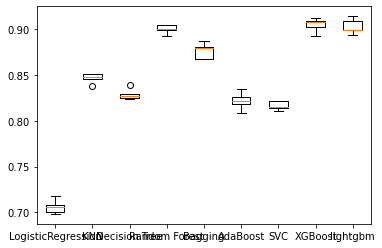

In [28]:
plt.boxplot(results, labels=models.keys())
plt.show()

In [29]:
for name, model in models.items():
    model.fit(X_train_s, y_train_s)
    train_score = model.score(X_train_s, y_train_s)
    test_score = model.score(X_test_s, y_test)
    print(f"{name} Train Set Accuracy: {train_score} \n{name} Test Set Accuracy: {test_score} \n ")

LogisticRegression Train Set Accuracy: 0.7068911264946507 
LogisticRegression Test Set Accuracy: 0.7245 
 
KNN Train Set Accuracy: 0.9036343612334802 
KNN Test Set Accuracy: 0.748 
 
Decision Tree Train Set Accuracy: 1.0 
Decision Tree Test Set Accuracy: 0.758 
 
Random Forest Train Set Accuracy: 1.0 
Random Forest Test Set Accuracy: 0.841 
 
Bagging Train Set Accuracy: 0.9939427312775331 
Bagging Test Set Accuracy: 0.8245 
 
AdaBoost Train Set Accuracy: 0.8253618628067967 
AdaBoost Test Set Accuracy: 0.8115 
 
SVC Train Set Accuracy: 0.8391283826305853 
SVC Test Set Accuracy: 0.7905 
 
XGBoost Train Set Accuracy: 0.9707363121460038 
XGBoost Test Set Accuracy: 0.854 
 
lightgbm Train Set Accuracy: 0.935179358086847 
lightgbm Test Set Accuracy: 0.861 
 


|                    	| LogisticRegression 	|   KNN   	| Decision Tree 	| Random Forest 	| Bagging 	| AdaBoost 	|   SVC   	| XGBoost 	| LightGBM 	|
|:------------------:	|:------------------:	|:-------:	|:-------------:	|:-------------:	|:-------:	|:--------:	|:-------:	|:-------:	|:--------:	|
| Train Set Accuracy 	|            0.75574 	| 0.88224 	|       1.00000 	|       1.00000 	| 0.99166 	|  0.84943 	| 0.86580 	| 0.95957 	|  0.91787 	|
| Test Set Accuracy  	|            0.72450 	| 0.76700 	|       0.76150 	|       0.84100 	| 0.82150 	|  0.81850 	| 0.81600 	| 0.83050 	|  0.83800 	|

### Coefficient / Feature Importance

In [30]:
def find_coef(feat, model_name):
    coef = pd.DataFrame(zip(feat,model_name.feature_importances_), columns=['feature', 'coef'])
    coef['abs_coef'] = coef['coef'].apply(lambda x: abs(x))
    return coef

In [31]:
find_coef(X_test.columns, models['Random Forest'])

,feature,coef,abs_coef
0,customer_id,0.076293,0.076293
1,credit_score,0.075927,0.075927
2,country,0.030152,0.030152
3,gender,0.022035,0.022035
4,age,0.239813,0.239813
5,tenure,0.067602,0.067602
6,balance,0.091454,0.091454
7,products_number,0.162436,0.162436
8,credit_card,0.013728,0.013728
9,active_member,0.039629,0.039629


In [32]:
find_coef(X_test.columns, models['AdaBoost'])

,feature,coef,abs_coef
0,customer_id,0.04,0.04
1,credit_score,0.02,0.02
2,country,0.00,0.00
3,gender,0.02,0.02
4,age,0.24,0.24
5,tenure,0.46,0.46
6,balance,0.00,0.00
7,products_number,0.08,0.08
8,credit_card,0.00,0.00
9,active_member,0.02,0.02


In [33]:
find_coef(X_test.columns, models['XGBoost'])

,feature,coef,abs_coef
0,customer_id,0.018167,0.018167
1,credit_score,0.017501,0.017501
2,country,0.055100,0.055100
3,gender,0.049102,0.049102
4,age,0.133467,0.133467
5,tenure,0.091916,0.091916
6,balance,0.036544,0.036544
7,products_number,0.344521,0.344521
8,credit_card,0.017867,0.017867
9,active_member,0.143094,0.143094


In [34]:
find_coef(X_test.columns, models['lightgbm'])

,feature,coef,abs_coef
0,customer_id,241,241
1,credit_score,244,244
2,country,51,51
3,gender,96,96
4,age,734,734
5,tenure,419,419
6,balance,275,275
7,products_number,208,208
8,credit_card,30,30
9,active_member,97,97


## 3. Reselect the Features based on Base Model and SelectKBest
---

In [35]:
# define X_train and y_train
X_train1 = df_train[['estimated_salary', 'balance', 'age','credit_score', 'country*balance','products_number','gender']]
y_train1 = df_train['churn']

In [36]:
# define X_train and y_train
X_test1 = df_test[['estimated_salary', 'balance', 'age','credit_score', 'country*balance','products_number','gender']]
y_test1 = df_test['churn']

### Scaling the Data

In [37]:
# Scaling
X_train1_s = ss.fit_transform(X_train1)
X_test1_s = ss.transform(X_test1)

### Balance the Data

In [38]:
Counter(y_train1)

Counter({0: 6356, 1: 1644})

In [39]:
X_train1_s, y_train1_s = smote.fit_resample(X_train1_s, y_train1)
Counter(y_train1_s)

Counter({0: 6356, 1: 6356})

### Modelling

In [40]:
for name, model in models.items():
    model.fit(X_train1_s, y_train1_s)
    train_score = model.score(X_train1_s, y_train1_s)
    test_score = model.score(X_test1_s, y_test1)
    print(f"{name} Train Set Accuracy: {train_score} \n{name} Test Set Accuracy: {test_score} \n ")

LogisticRegression Train Set Accuracy: 0.7047671491504091 
LogisticRegression Test Set Accuracy: 0.712 
 
KNN Train Set Accuracy: 0.8964757709251101 
KNN Test Set Accuracy: 0.7475 
 
Decision Tree Train Set Accuracy: 1.0 
Decision Tree Test Set Accuracy: 0.7645 
 
Random Forest Train Set Accuracy: 1.0 
Random Forest Test Set Accuracy: 0.829 
 
Bagging Train Set Accuracy: 0.9924480805538074 
Bagging Test Set Accuracy: 0.8205 
 
AdaBoost Train Set Accuracy: 0.7945248584015104 
AdaBoost Test Set Accuracy: 0.7865 
 
SVC Train Set Accuracy: 0.7960981749528006 
SVC Test Set Accuracy: 0.7805 
 
XGBoost Train Set Accuracy: 0.9498898678414097 
XGBoost Test Set Accuracy: 0.842 
 
lightgbm Train Set Accuracy: 0.9128382630585273 
lightgbm Test Set Accuracy: 0.842 
 


|                    	| LogisticRegression 	|   KNN   	| Decision Tree 	| Random Forest 	| Bagging 	| AdaBoost 	|   SVC   	| XGBoost 	| LightGBM 	|
|:------------------:	|:------------------:	|:-------:	|:-------------:	|:-------------:	|:-------:	|:--------:	|:-------:	|:-------:	|:--------:	|
| Train Set Accuracy 	|            0.70477 	| 0.89648 	|       1.00000 	|       1.00000 	| 0.99245 	|  0.79452 	| 0.79610 	| 0.94989 	|  0.91284 	|
| Test Set Accuracy  	|            0.71200 	| 0.74750 	|       0.77050 	|       0.82450 	| 0.82500 	|  0.78650 	| 0.78050 	| 0.84200 	|  0.84200 	|

### Recall Score

In [41]:
from sklearn.metrics import recall_score

In [42]:
for name, model in models.items():
    y_pred_train1 = model.predict(X_train1_s)
    y_pred_test1 = model.predict(X_test1_s)
    print(f"{name} recall_train_score: {recall_score(y_train1_s, y_pred_train1)}\n\
    {name} recall_test_score: {recall_score(y_test1, y_pred_test1)}\n")

LogisticRegression recall_train_score: 0.6823473882945249
    LogisticRegression recall_test_score: 0.6972010178117048

KNN recall_train_score: 0.9652297042164883
    KNN recall_test_score: 0.6717557251908397

Decision Tree recall_train_score: 1.0
    Decision Tree recall_test_score: 0.549618320610687

Random Forest recall_train_score: 1.0
    Random Forest recall_test_score: 0.6208651399491094

Bagging recall_train_score: 0.9894587791063562
    Bagging recall_test_score: 0.55470737913486

AdaBoost recall_train_score: 0.7769037130270611
    AdaBoost recall_test_score: 0.7430025445292621

SVC recall_train_score: 0.7924795468848332
    SVC recall_test_score: 0.7659033078880407

XGBoost recall_train_score: 0.93313404657017
    XGBoost recall_test_score: 0.5597964376590331

lightgbm recall_train_score: 0.8920704845814978
    lightgbm recall_test_score: 0.6005089058524173



### F1 Score

In [43]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

In [44]:
for name, model in models.items():
    y_pred_train1 = model.predict(X_train1_s)
    y_pred_test1 = model.predict(X_test1_s)
    print(f"{name} y_pred_train: {y_pred_train1.mean()}\n\
    {name} f1_train_score: {f1_score(y_train1_s, y_pred_train1)}\n\
    {name} y_pred_test: {y_pred_test1.mean()}\n\
    {name} f1_test_score: {f1_score(y_test1, y_pred_test1)}\n")

LogisticRegression y_pred_train: 0.4775802391441158
    LogisticRegression f1_train_score: 0.6979962983825542
    LogisticRegression y_pred_test: 0.3655
    LogisticRegression f1_test_score: 0.48754448398576516

KNN y_pred_train: 0.5687539332913782
    KNN f1_train_score: 0.9031355807448845
    KNN y_pred_test: 0.32
    KNN f1_test_score: 0.511132623426912

Decision Tree y_pred_train: 0.5
    Decision Tree f1_train_score: 1.0
    Decision Tree y_pred_test: 0.255
    Decision Tree f1_test_score: 0.4784053156146179

Random Forest y_pred_train: 0.5
    Random Forest f1_train_score: 1.0
    Random Forest y_pred_test: 0.2185
    Random Forest f1_test_score: 0.5879518072289156

Bagging y_pred_train: 0.49701069855254876
    Bagging f1_train_score: 0.9924254379043712
    Bagging y_pred_test: 0.201
    Bagging f1_test_score: 0.5484276729559748

AdaBoost y_pred_train: 0.48237885462555063
    AdaBoost f1_train_score: 0.7908392056374118
    AdaBoost y_pred_test: 0.309
    AdaBoost f1_test_score: 0

### ROC
---

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be remov

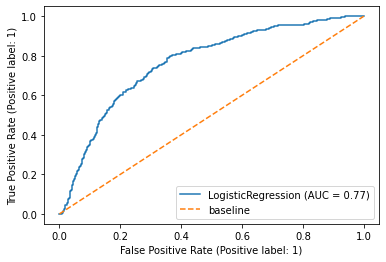

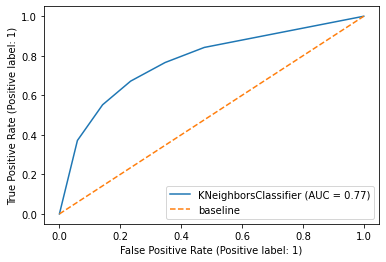

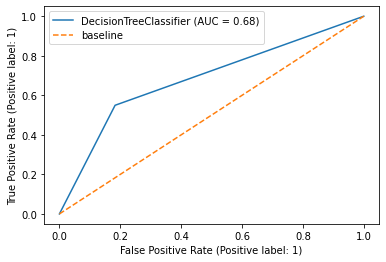

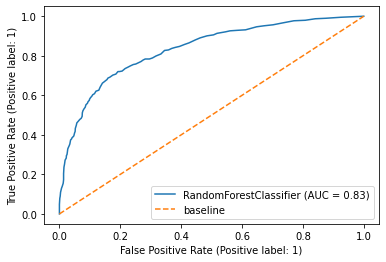

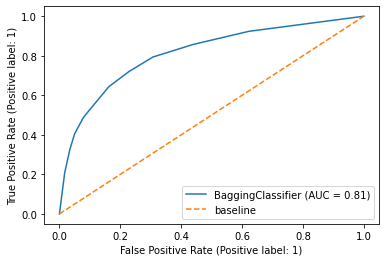

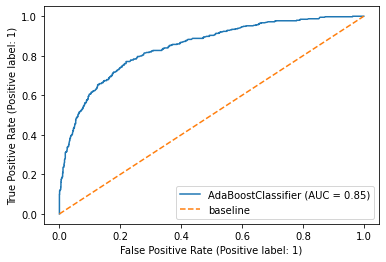

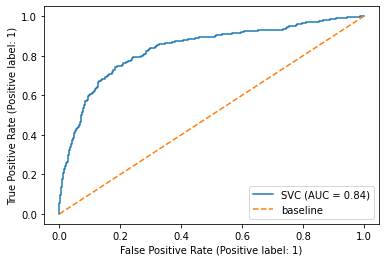

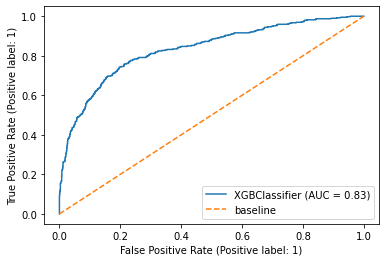

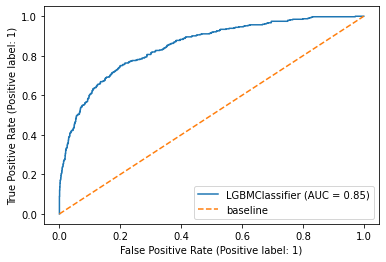

In [45]:
for name, model in models.items():
    plot_roc_curve(model, X_test1_s, y_test1)
    plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
    plt.legend()

|                               	|     LogisticRegression 	|       KNN   	|     Decision Tree 	|     Random Forest 	|     Bagging 	|     AdaBoost 	|       SVC   	|     XGBoost 	|     LightGBM    	|
|:-----------------------------:	|:----------------------:	|:-----------:	|:-----------------:	|:-----------------:	|:-----------:	|:------------:	|:-----------:	|:-----------:	|:---------------:	|
|     Train Set Accuracy        	|                0.70477 	|     0.89648 	|           1.00000 	|           1.00000 	|     0.99245 	|      0.79452 	|     0.79610 	|     0.94989 	|      0.91284    	|
|     Test Set Accuracy         	|                0.71200 	|     0.74750 	|           0.77050 	|           0.82450 	|     0.82500 	|      0.78650 	|     0.78050 	|     0.84200 	|      0.84200    	|
|     Train Set Precision Score 	|                0.71438 	|     0.84855 	|           1.00000 	|           1.00000 	|     0.99667 	|      0.80528 	|     0.79826 	|     0.96549 	|         0.93073 	|
|     Test Set Precision Score  	|                0.37483 	|     0.41250 	|           0.41923 	|           0.55381 	|     0.51961 	|      0.47249 	|     0.46451 	|     0.60606 	|         0.59747 	|
|     Train Set F1 Score        	|                0.69800 	|     0.90314 	|           1.00000 	|           1.00000 	|     0.99242 	|      0.79084 	|     0.79536 	|     0.94904 	|      0.91099    	|
|     Test F1 Set F1 Score      	|                0.48754 	|     0.51113 	|           0.48600 	|           0.58264 	|     0.55357 	|      0.57765 	|     0.57829 	|     0.58201 	|      0.59898    	|
|     AUC                       	|                0.77000 	|     0.77000 	|           0.69000 	|           0.83000 	|     0.80000 	|      0.85000 	|     0.84000 	|     0.83000 	|      0.85000    	|

Based on the accuracy score, F1 score and ROC, we will zoom down to five models:

1. Random Forest
2. SVC
3. AdaBoost
4. XGBoost
5. LightGBM

## 4. Refine the Model
---

### PolynomialFeatures

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from imblearn.pipeline import Pipeline 

In [46]:
models1 = {
          "Random Forest": RandomForestClassifier(random_state=s),
          "SVC": SVC(random_state=s),
          "AdaBoost": AdaBoostClassifier(random_state=s),
          "XGBoost": xgb.XGBClassifier(seed=s),
          "lightgbm": lgb.LGBMClassifier(random_state=s)
          }

In [39]:
score={}
for name, m in models1.items():
    for d in range(2,5):
        pipe = Pipeline(steps=[
            ('poly',PolynomialFeatures(degree = d)),
            ('scale',StandardScaler()),
            ('resample', smote),
            ('model', m)
            ])
        
        pipe.fit(X_train1, y_train1)
        
        # add train score and test score to score for each number of features and polynomial degree
        score[name,d]=[pipe.score(X_train1, y_train1),pipe.score(X_test1, y_test1)]

In [40]:
score

{('Random Forest', 2): [1.0, 0.82],
 ('Random Forest', 3): [1.0, 0.818],
 ('Random Forest', 4): [1.0, 0.816],
 ('SVC', 2): [0.79275, 0.7735],
 ('SVC', 3): [0.790375, 0.773],
 ('SVC', 4): [0.78625, 0.772],
 ('AdaBoost', 2): [0.804875, 0.789],
 ('AdaBoost', 3): [0.797375, 0.7725],
 ('AdaBoost', 4): [0.79775, 0.7735],
 ('XGBoost', 2): [0.948875, 0.83],
 ('XGBoost', 3): [0.960625, 0.8335],
 ('XGBoost', 4): [0.972625, 0.8335],
 ('lightgbm', 2): [0.899375, 0.8425],
 ('lightgbm', 3): [0.905375, 0.8405],
 ('lightgbm', 4): [0.914625, 0.8415]}

PolynomialFeatures did not improve the scores, hence we will not apply it.

### Gridsearch

In [47]:
from sklearn.model_selection import GridSearchCV

**Random Forest**

In [48]:
rf_params = {
    'n_estimators': range(100,500,100),
    'criterion': ('gini', 'entropy','log_loss'),
    'max_depth': (5,7,10,15,20,30),
    'ccp_alpha': (0.001,0.01,0.05,0.1)
}
                   
# with GridSearch
rf_gs = GridSearchCV(
    models1['Random Forest'],
    param_grid=rf_params,
    scoring = ['recall','accuracy'],
    refit='accuracy',
    cv = 5)

rf_gs.fit(X_train1_s, y_train1_s)
print(rf_gs.best_score_)
rf_gs.best_params_

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
480 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\ng_li\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\ng_li\anaconda3\lib\site-package

0.8274882408103824


{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 30,
 'n_estimators': 300}

**SVC**

In [49]:
svc_params = {
    'C': (1,2),
    'degree': (1,3,5),
    'gamma': ('scale','auto'),
    'decision_function_shape': ('ovo', 'ovr')
}
                   
# with GridSearch
svc_gs = GridSearchCV(
    models1['SVC'],
    param_grid=svc_params,
    scoring = ['recall','accuracy'],
    refit='accuracy',
    cv = 5)

svc_gs.fit(X_train1_s, y_train1_s)
print(svc_gs.best_score_)
svc_gs.best_params_

0.7932670885320094


{'C': 2, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'auto'}

**Adaboost**

In [50]:
adaboost_params = {
    'n_estimators': range(100,500,100),
    'learning_rate': (0.05, 0.1, 0.5, 1)
}
                   
# with GridSearch
adaboost_gs = GridSearchCV(
    models1['AdaBoost'],
    param_grid=adaboost_params,
    scoring = ['recall','accuracy'],
    refit='accuracy',
    cv = 5)

adaboost_gs.fit(X_train1_s, y_train1_s)
print(adaboost_gs.best_score_)
adaboost_gs.best_params_

0.826468548982675


{'learning_rate': 1, 'n_estimators': 400}

**XGBoost**

In [51]:
xgb_params = {
    'gamma': (0,0.1,0.2,0.5,1),
    'eta': (0.05, 0.1, 0.2, 0.3),
    'max_depth': range(0,7)
}

# with GridSearch
xgb_gs = GridSearchCV(
    models1['XGBoost'],
    param_grid=xgb_params,
    scoring = ['recall','accuracy'],
    refit='accuracy',
    cv = 5)

xgb_gs.fit(X_train1_s, y_train1_s)
print(xgb_gs.best_score_)
xgb_gs.best_params_

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ng_li\anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\ng_li\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1516, in fit
    self._Booster = train(
  File "C:\Users\ng_li\anaconda3\lib\site-packages\xgboost\core.py", line 62

0.8782375091773194


{'eta': 0.3, 'gamma': 0, 'max_depth': 6}

**LightGBM**

In [53]:
lgb_params = {
    'num_leaves': (16,20,25,31),
    'max_depth': (-1,1,3,5),
    'learning_rate': (0.05,0.1,0.2,0.5),
    'n_estimators': range(100,500,100)
}
                   
# with GridSearch
lgb_gs = GridSearchCV(
    models1['lightgbm'],
    param_grid=lgb_params,
    scoring = ['recall','accuracy'],
    refit='accuracy',
    cv = 5)

lgb_gs.fit(X_train1_s, y_train1_s)
print(lgb_gs.best_score_)
lgb_gs.best_params_

0.8846080306223127


{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 31}

| Model         	| Best Params for Recall Score                                                   	|
|---------------	|--------------------------------------------------------------------------------	|
| Random Forest 	| {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 300}   	|
| SVC           	| {'C': 2, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'auto'}       	|
| Adaboost      	| {'learning_rate': 1, 'n_estimators': 400}                                      	|
| XGBoost       	| {'eta': 0.3, 'gamma': 0, 'max_depth': 6}                                     	|
| LightGBM      	| {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 31} 	|

## Models Evaluation
---

In [48]:
models_final = {
    "Random Forest": RandomForestClassifier(ccp_alpha=0.001,
                                            criterion='entropy',
                                            max_depth=30,
                                            n_estimators= 300,
                                            random_state=s
                                           ),
    "SVC": SVC(C=2, decision_function_shape = 'ovo', degree = 1, gamma='auto', random_state=s),
    "AdaBoost": AdaBoostClassifier(learning_rate=1, n_estimators=400,
                                  random_state=s
                                 ),
    "XGBoost": xgb.XGBClassifier(eta=0.3, gamma=0, max_depth=6, seed=s),
    "lightgbm": lgb.LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=300, num_leaves=31, random_state=s)
}

Random Forest Train Set Accuracy: 0.8502202643171806 
Random Forest Test Set Accuracy: 0.8055 
 


C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Random Forest precision_train_score: 0.8494505494505494
    Random Forest precision_test_score: 0.503584229390681

Random Forest recall_train_score: 0.8513215859030837
    Random Forest recall_test_score: 0.7150127226463104

Random Forest f1_score_train: 0.8503850385038504
    Random Forest f1_score_test: 0.5909568874868559



C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


SVC Train Set Accuracy: 0.8040434235368156 
SVC Test Set Accuracy: 0.7795 
 
SVC precision_train_score: 0.8042827901117934
    SVC precision_test_score: 0.46261682242990654

SVC recall_train_score: 0.803650094398993
    SVC recall_test_score: 0.7557251908396947

SVC f1_score_train: 0.8039663177776029
    SVC f1_score_test: 0.5739130434782609



C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


AdaBoost Train Set Accuracy: 0.8379483952171177 
AdaBoost Test Set Accuracy: 0.8085 
 


C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AdaBoost precision_train_score: 0.8451156812339332
    AdaBoost precision_test_score: 0.509090909090909

AdaBoost recall_train_score: 0.8275645059786029
    AdaBoost recall_test_score: 0.712468193384224

AdaBoost f1_score_train: 0.8362480127186009
    AdaBoost f1_score_test: 0.5938494167550371



C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


XGBoost Train Set Accuracy: 0.9498898678414097 
XGBoost Test Set Accuracy: 0.842 
 
XGBoost precision_train_score: 0.9654891746703566
    XGBoost precision_test_score: 0.6060606060606061

XGBoost recall_train_score: 0.93313404657017
    XGBoost recall_test_score: 0.5597964376590331

XGBoost f1_score_train: 0.9490359228738299
    XGBoost f1_score_test: 0.5820105820105821



C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


lightgbm Train Set Accuracy: 0.9655443675267463 
lightgbm Test Set Accuracy: 0.838 
 
lightgbm precision_train_score: 0.9805131536213056
    lightgbm precision_test_score: 0.5929919137466307

lightgbm recall_train_score: 0.9499685336689742
    lightgbm recall_test_score: 0.5597964376590331

lightgbm f1_score_train: 0.9649992008949976
    lightgbm f1_score_test: 0.5759162303664921



C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


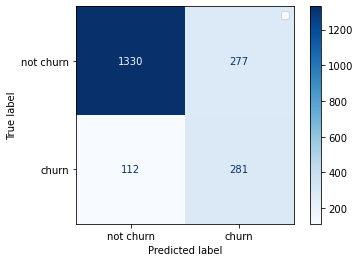

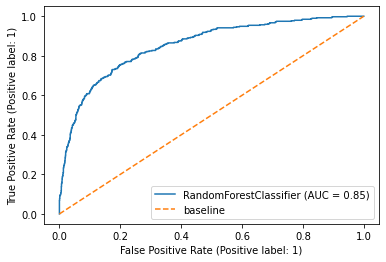

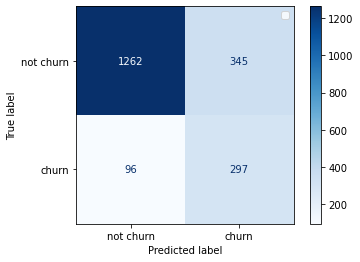

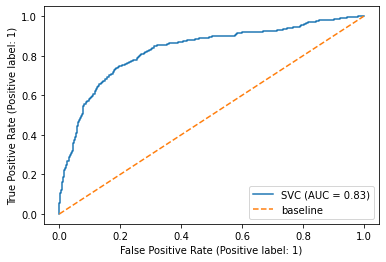

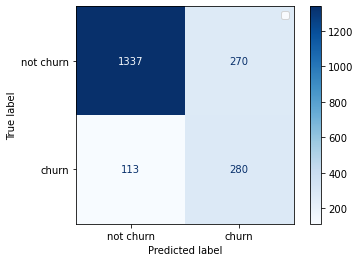

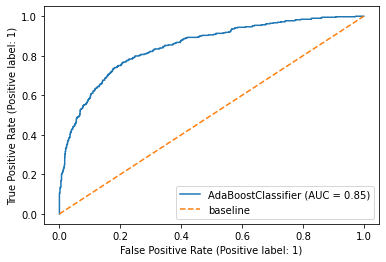

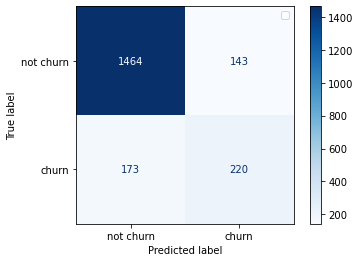

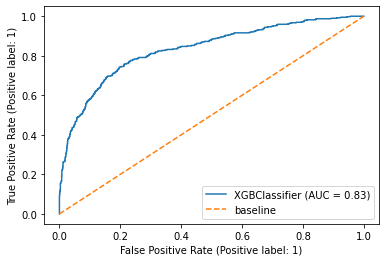

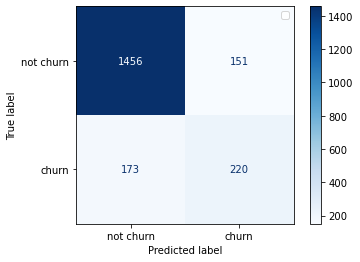

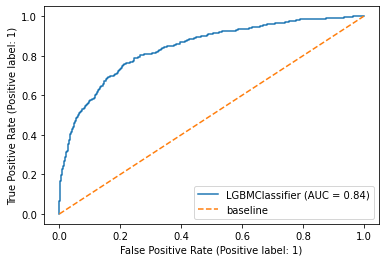

In [49]:
for name, model in models_final.items():
    
    #acurracy sccore
    model.fit(X_train1_s, y_train1_s)
    train_score = model.score(X_train1_s, y_train1_s)
    test_score = model.score(X_test1_s, y_test1)
    print(f"{name} Train Set Accuracy: {train_score} \n{name} Test Set Accuracy: {test_score} \n ")
    
    y_pred_train1 = model.predict(X_train1_s)
    y_pred_test1 = model.predict(X_test1_s)
    
    
    #precision_score
    print(f"{name} precision_train_score: {precision_score(y_train1_s, y_pred_train1)}\n\
    {name} precision_test_score: {precision_score(y_test1, y_pred_test1)}\n")
    
    #recall_score
    print(f"{name} recall_train_score: {recall_score(y_train1_s, y_pred_train1)}\n\
    {name} recall_test_score: {recall_score(y_test1, y_pred_test1)}\n")
    
    #F1 score
    print(f"{name} f1_score_train: {f1_score(y_train1_s, y_pred_train1)}\n\
    {name} f1_score_test: {f1_score(y_test1, y_pred_test1)}\n")
    
    #Confusion Matrix
    confusion_matrix(y_test1, 
                 y_pred_test1)
    
    plot_confusion_matrix(model, X_test1_s, y_test1, cmap='Blues', 
                      values_format='d', display_labels=['not churn', 'churn'])
    plt.legend()
    
    plot_roc_curve(model, X_test1_s, y_test1)
    plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
    plt.legend()

|                             	| Random Forest 	|   SVC   	| AdaBoost 	| XGBoost 	| LightGBM    	|
|:---------------------------:	|:-------------:	|:-------:	|:--------:	|:-------:	|:-----------:	|
| Train Set   Accuracy        	|    0.85022    	| 0.80404 	|  0.83795 	| 0.94989 	|   0.96554   	|
| Test Set   Accuracy         	|    0.80550    	|  0.7795 	|  0.80850 	| 0.84200 	|   0.83800   	|
| Train Set   Precision Score 	|    0.84945    	| 0.80428 	|  0.84512 	| 0.96549 	|   0.98051   	|
| Test Set   Precision Score  	|    0.50358    	| 0.46262 	|  0.50909 	| 0.60606 	|   0.59300   	|
| Train Set Recall Score      	|    0.85132    	| 0.80365 	|  0.82756 	| 0.93313 	|   0.94997   	|
| Test Set Recall Score       	|    0.71501    	| 0.75573 	|  0.71247 	| 0.55980 	|   0.55980   	|
| Train Set   F1 Score        	|    0.85039    	| 0.80397 	|  0.83625 	| 0.94904 	|   0.96500   	|
| Test F1   Set F1 Score      	|    0.59096    	| 0.57391 	|  0.59385 	| 0.58201 	|   0.57592   	|
| AUC                         	|    0.85000    	| 0.83000 	|  0.85000 	| 0.83000 	|  0.84000    	|

Our goal is to reduce Type 2 error or False Negatives
False negative in our case will be customers whom we predicted will not churn, but in  reality churned.

We want to reduce such errors because if we predicted that a customer will not churn but in fact he / she churned, then we lost a customer.

In the opposite case however, where we predicted that a customer will churn and the customer actually did not churn, we would spend resources/effort to try to retain the customer which could have been redirected.

Hence, reducing type 2 error is more important as losing a customer cost more than spending resources on the wrong targeted customer.

In another words, we want to predict the customer who will churn as accurately as possible.
This will help us to direct resources to the right customers and help retain the customer.
Therefore, precision is an important metric in our model.

Given that our goal is to reduce type 2 error, recall score is the most important metric to us, followed by accuracy score.

SVC gives the highest recall score and the lowest accuracy score.
SVC also has slow performance if the dataset is huge, which is probable in a bank.

Random Forest gives the second highest recall score and about 80.55% accuracy.
Its AUC score is also higher than SVC.
Thus, we will deploy Random Forest as our final model.

## 5. Final Model - Random Forest
---

In [50]:
model_clf = RandomForestClassifier(ccp_alpha=0.001,
                                            criterion='entropy',
                                            max_depth=30,
                                            n_estimators= 300,
                                            random_state=s
                                           )

Train Set Accuracy: 0.8502202643171806 
 Test Set Accuracy: 0.8055 
 


C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


precision_train_score: 0.8513215859030837
precision_test_score: 0.7150127226463104 

f1_score_train: 0.8503850385038504
f1_score_test: 0.5909568874868559



C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


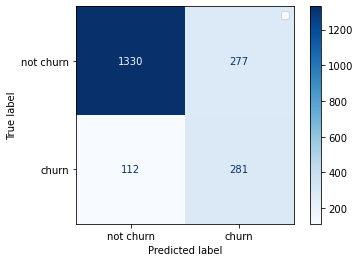

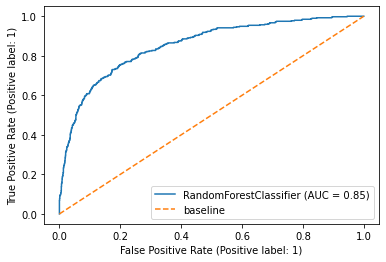

In [51]:
#acurracy sccore
model_clf.fit(X_train1_s, y_train1_s)
train_score = model_clf.score(X_train1_s, y_train1_s)
test_score = model_clf.score(X_test1_s, y_test1)
print(f"Train Set Accuracy: {train_score} \n Test Set Accuracy: {test_score} \n ")
    
y_pred_train1 = model_clf.predict(X_train1_s)
y_pred_test1 = model_clf.predict(X_test1_s)
    
    
#precision_score
print(f"precision_train_score: {recall_score(y_train1_s, y_pred_train1)}\n\
precision_test_score: {recall_score(y_test1, y_pred_test1)} \n")
    
#F1 score
print(f"f1_score_train: {f1_score(y_train1_s, y_pred_train1)}\n\
f1_score_test: {f1_score(y_test1, y_pred_test1)}\n")
    
#Confusion Matrix
confusion_matrix(y_test1, 
                 y_pred_test1)
    
plot_confusion_matrix(model_clf, X_test1_s, y_test1, cmap='Blues', 
                      values_format='d', display_labels=['not churn', 'churn'])
plt.legend()

#ROC AUC
plot_roc_curve(model_clf, X_test1_s, y_test1)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend()

**Coefficient**

In [52]:
coef = pd.DataFrame(zip(X_test1 .columns,model_clf.feature_importances_), columns=['feature', 'coef'])
coef['abs_coef'] = coef['coef'].apply(lambda x: abs(x))
coef = coef.sort_values('abs_coef', ascending=False)
coef

,feature,coef,abs_coef
2,age,0.377944,0.377944
5,products_number,0.279804,0.279804
4,country*balance,0.119489,0.119489
1,balance,0.089736,0.089736
0,estimated_salary,0.060102,0.060102
3,credit_score,0.050558,0.050558
6,gender,0.022367,0.022367


### Save the model

In [53]:
import pickle

In [54]:
with open("..\App\Model\enc_clf.pkl", "wb") as to_save:
     pickle.dump(enc, to_save)

In [55]:
with open("..\App\Model\ohe_clf.pkl", "wb") as to_save:
     pickle.dump(ohe, to_save)

In [56]:
with open("..\App\Model\ss_clf.pkl", "wb") as to_save:
     pickle.dump(ss, to_save)

In [57]:
with open("..\App\Model\lightgbm.pkl", "wb") as to_save:
     pickle.dump(model_clf, to_save)

## 6. Shap Explanation
---

In [58]:
import shap

In [59]:
shap.initjs()

In [60]:
explainer = shap.TreeExplainer(model_clf)

In [61]:
shap_values = explainer.shap_values(X_test1_s)

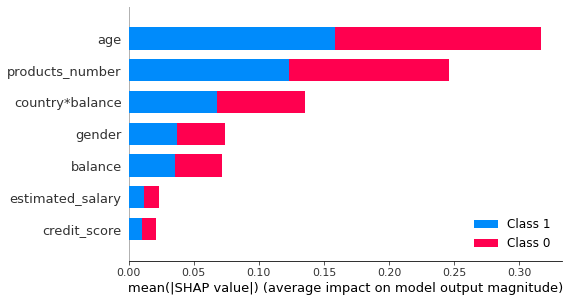

In [62]:
shap.summary_plot(shap_values, X_test1, plot_type="bar")

Age is the most important contributing feature to the model, followed by product_number and country x balance

### Visualize Single Prediction

In [63]:
X_test1.iloc[0,:]

estimated_salary     41788.37
balance              96709.07
age                     32.00
credit_score           596.00
country*balance     193418.14
products_number          2.00
gender                   1.00
Name: 0, dtype: float64

In [64]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test1.iloc[0,:])

This client has lower tendancy to churn given his age, number of products and his gender.

On the other hand the country x balance feature pushes him to churn.

In [65]:
X_test1.iloc[3,:]

estimated_salary    170679.74
balance             119152.10
age                     59.00
credit_score           506.00
country*balance     238304.20
products_number          2.00
gender                   1.00
Name: 3, dtype: float64

In [66]:
shap.force_plot(explainer.expected_value[1], shap_values[1][3,:], X_test1.iloc[3,:])

This client is likely to churn given the age, country x balance, and balance features

The number of products and gender features have negative effect on him churning.

### Visualize 1,000 Predictions

In [67]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_test1.iloc[:1000,:])

The above chart shows a sample of 1,000 clients.

It is an interactive chart that shows each feature contributing to push the model output towards the base value (churn).